
 <img src="" alt="add images here" width="100%"/>
 

# Analysis

In [1]:
# Import dependancies
import os
import requests
import pandas as pd
import json
from dotenv import load_dotenv
from etherscan_py import etherscan_py

In [2]:
# Loading .env containing our keys
load_dotenv()

True

In [3]:
# create variable for api key 
api_key = os.getenv('COVALENT_API_KEY')
type(api_key)

str

## Current value of ETH

In [4]:
# import dependancy
from etherscan_py import etherscan_py
client = etherscan_py.Client(os.getenv('ETHERSCAN_API'))

# Print current eth price and latest block height
eth_value = client.get_eth_price()
eth_value

2923.57

## Set variables

In [5]:
# Append url for our api
url = "https://api.covalenthq.com/v1"
chain_id = "/1"
azuki_address = "/0xED5AF388653567Af2F388E6224dC7C4b3241C544"
cryptopunks_address = "/0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB"
BAYC_address = "/0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D"
date_option = '/?quote-currency=USD&format=JSON&from=2017-01-01&to=2022-05-01'
page_option = '/transactions_v2/?quote-currency=USD&format=JSON&block-signed-at-asc=false&no-logs=false&page-number=0&page-size=1000'
api_option = "&key=" + api_key
api_no_option = '/?key=' + api_key

## Concating all Owner metadata

In [12]:
# Append variable to url to get token owners
owner_url = url + chain_id + "/tokens" + azuki_address + "/nft_metadata" + '/' + '0' + api_no_option

# Get request
owner_data = requests.get(owner_url).json()

# Convert Owner json data to a dataframe and view data
owner_data_df = pd.DataFrame(owner_data['data']['items'][0]['nft_data'], columns = ['token_id', 'owner_address', 'burned'])

# Create empty dataframe for token_owner DataFrame
owner_columns = owner_data_df.columns

In [13]:
# Creating a new empty DataFrame to append all nft owner data rows into
token_owners = pd.DataFrame(columns = owner_columns)

# Show Token owner empty dataframes
token_owners

,token_id,owner_address,burned


In [14]:
# Loop through owner data and add into empty token_owners dataframe range = 100
for token_id in range(100):
    owner_url = url + chain_id + '/tokens' + azuki_address + '/nft_metadata/' + str(token_id) + api_no_option
    
    # Get Request and convert json to dataframe
    owner_data = requests.get(owner_url).json() 
    df = pd.DataFrame(owner_data['data']['items'][0]['nft_data'], columns = ['token_id', 'owner_address', 'burned'])
   
    token_owners.loc[token_id] = [df.iloc[0]['token_id'], df.iloc[0]['owner_address'], df.iloc[0]['burned']]

In [15]:
# Show token owner data
token_owners.head()

,token_id,owner_address,burned
0,0,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False
1,1,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False
2,2,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False
3,3,0x645d2b4bfb047566ff60e2e7112373885935eac4,False
4,4,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False


## 1. Azuki NFT Historical volume data 

In [16]:
# Create variables needed for owner data and add to url
historical_url = url + chain_id + "/nft_market/collection" + azuki_address + api_no_option

# Get request
azuki_historical_json = requests.get(historical_url).json()

# Convert historical json data to a dataframe and view data
azuki_df = pd.DataFrame(azuki_historical_json['data']['items'])

# Set index to date
azuki_df = azuki_df.set_index('opening_date')

# Create Volume dataframe
azuki_vol_df = pd.DataFrame(azuki_df, columns = ['volume_quote_day', 'unique_token_ids_sold_count_day']).sort_index()
azuki_vol_df

,volume_quote_day,unique_token_ids_sold_count_day
opening_date,,
2022-01-12,45941404.0,2402
2022-01-13,25129178.0,1318
2022-01-14,168151840.0,470
2022-01-15,4408686.0,499
2022-01-16,295638336.0,368
...,...,...
2022-04-02,24722180.0,193
2022-04-03,9899117.0,64
2022-04-04,4517060.5,40


<AxesSubplot:xlabel='opening_date'>

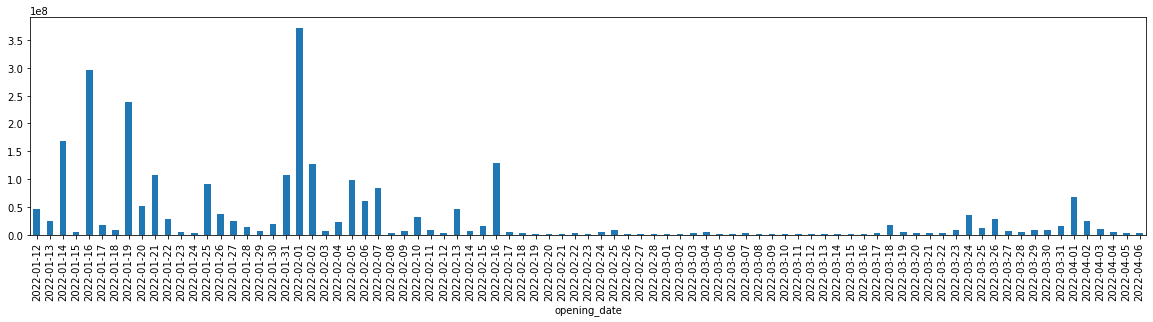

In [17]:
# Plot Volume quote per day
azuki_volume = azuki_vol_df['volume_quote_day'].astype(int)

azuki_volume.plot.bar(figsize = (20,4))

## 1a Historical Sales + Fees paid

In [18]:
# Quering the API for transaction data
azuki_tx_url = url + chain_id + "/address" + azuki_address + page_option + api_option 
azuki_tx = requests.get(azuki_tx_url).json()

# Convert transactions data to dataframe
azuki_tx_df = pd.DataFrame(azuki_tx['data']['items'], columns = ['to_address_label','fees_paid', 'value_quote','block_signed_at']).set_index('block_signed_at').sort_index()

azuki_tx_df.head()

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-05-02T04:41:05Z,Wyvern Exchange Contract (-),9412398750990962,99928.918835
2022-05-02T04:41:05Z,None,1189417992884451,0.000000
2022-05-02T04:52:14Z,Wyvern Exchange Contract (-),8291501386807069,82201.900330
2022-05-02T04:54:41Z,Wyvern Exchange Contract (-),9290625178370927,85061.096863
2022-05-02T04:58:25Z,None,2412472971072120,0.000000


## 1.a NFT Sales only Filter

<AxesSubplot:xlabel='block_signed_at'>

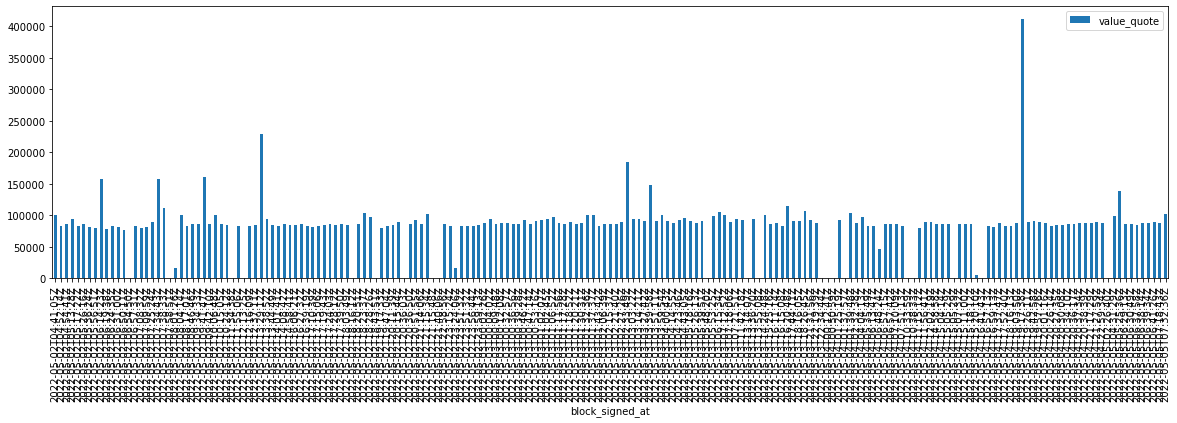

In [19]:
# Filter Through data for non null transactions
azuki_sales_df = azuki_tx_df[azuki_tx_df['value_quote'] != '0']
azuki_sales = azuki_sales_df[azuki_sales_df['to_address_label'].notnull()]

# View transaction data
azuki_sales.plot.bar(rot = 90, figsize = (20,5))

## 1.b Fees plot

<AxesSubplot:xlabel='value in USD'>

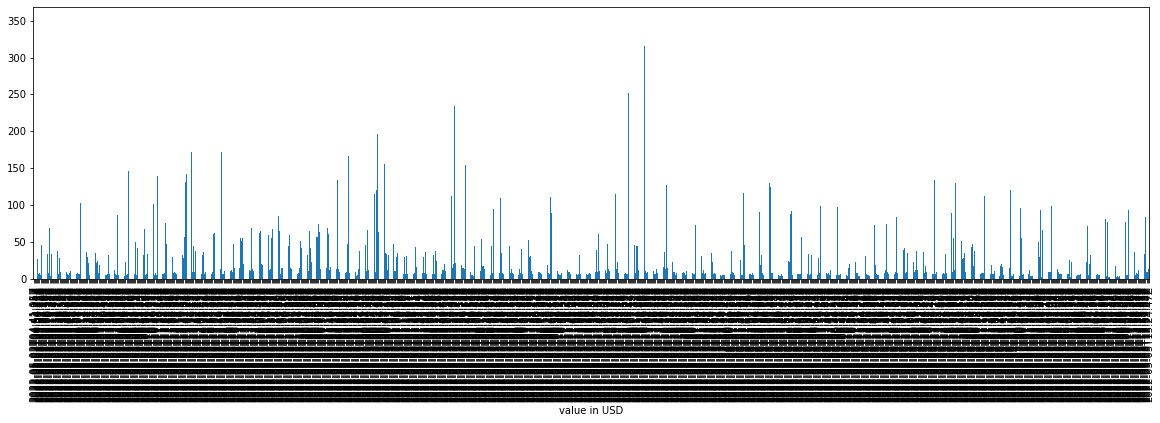

In [20]:
# Filter Through data for non null transactions
azuki_fees = azuki_sales_df['fees_paid'].astype(int)/10**18*eth_value

azuki_fees.plot.bar(rot = 90, figsize = (20,5), xlabel = 'value in USD')

## 2. Cryptopunks Daily Volume

In [21]:
# Create variables needed for owner data and append to url
cryptopunks_historical_url = url + chain_id + "/nft_market/collection" + cryptopunks_address + api_no_option

# Get request
cryptopunks_historical_json = requests.get(cryptopunks_historical_url).json()

# Convert historical json data to a dataframe and view data
cryptopunks_df = pd.DataFrame(cryptopunks_historical_json['data']['items'])

# Set index to date
cryptopunks_df = cryptopunks_df.set_index('opening_date')

# Create Volume dataframe
cryptopunks_vol_df = pd.DataFrame(cryptopunks_df, columns = ['volume_quote_day', 'unique_token_ids_sold_count_day']).sort_index()
cryptopunks_vol_df.head()

,volume_quote_day,unique_token_ids_sold_count_day
opening_date,,
2017-06-23,0.0,19
2017-06-24,0.0,22
2017-06-25,0.0,11
2017-06-26,0.0,18
2017-06-27,0.0,35


<AxesSubplot:xlabel='opening_date'>

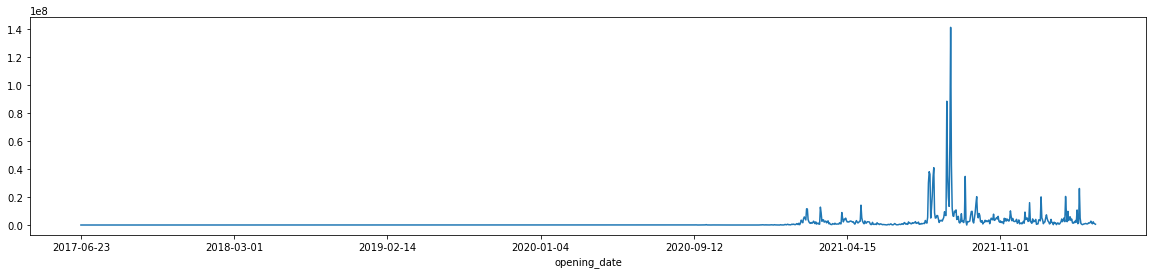

In [22]:
# Plot Volume quote per day
cryptopunks_volume = cryptopunks_vol_df['volume_quote_day'].astype(int)

cryptopunks_volume.plot.line(figsize = (20,4))

## 2a Historical Sales + Fees paid

In [23]:
# Quering the API for transaction data
cryptopunks_tx_url = url + chain_id + "/address" + cryptopunks_address + page_option + api_option 
cryptopunks_tx = requests.get(cryptopunks_tx_url).json()

# Convert transactions data to dataframe
cryptopunks_tx_df = pd.DataFrame(cryptopunks_tx['data']['items'], columns = ['to_address_label','fees_paid', 'value_quote','block_signed_at']).set_index('block_signed_at').sort_index()

cryptopunks_tx_df.head()

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-04-27T15:54:17Z,CRYPTOPUNKS (Ͼ),2570717295904326,0.0
2022-04-27T15:56:16Z,CRYPTOPUNKS (Ͼ),2486861503601748,0.0
2022-04-27T15:57:11Z,CRYPTOPUNKS (Ͼ),2491460796915363,0.0
2022-04-27T15:58:03Z,None,18078853212558943,0.0
2022-04-27T15:58:43Z,None,15497311210912036,0.0


<AxesSubplot:xlabel='block_signed_at'>

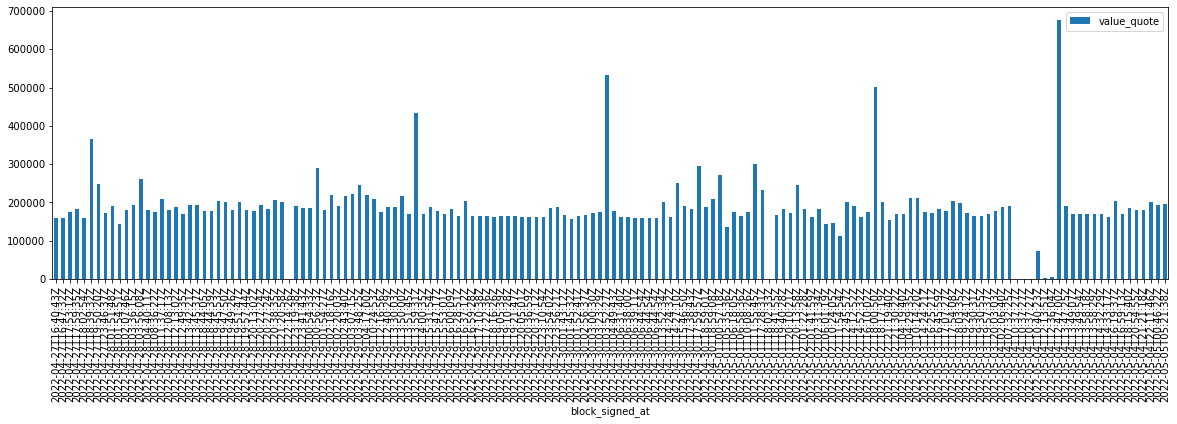

In [24]:
# Filter Through data for non null transactions
cryptopunks_sales_df = cryptopunks_tx_df[cryptopunks_tx_df['value_quote'] != 0]
cryptopunks_sales = cryptopunks_sales_df[cryptopunks_sales_df['to_address_label'].notnull()].dropna()

# View transaction data
cryptopunks_sales.plot.bar(rot = 90, figsize = (20,5))

## 2.b Fees plot

<AxesSubplot:xlabel='value in USD'>

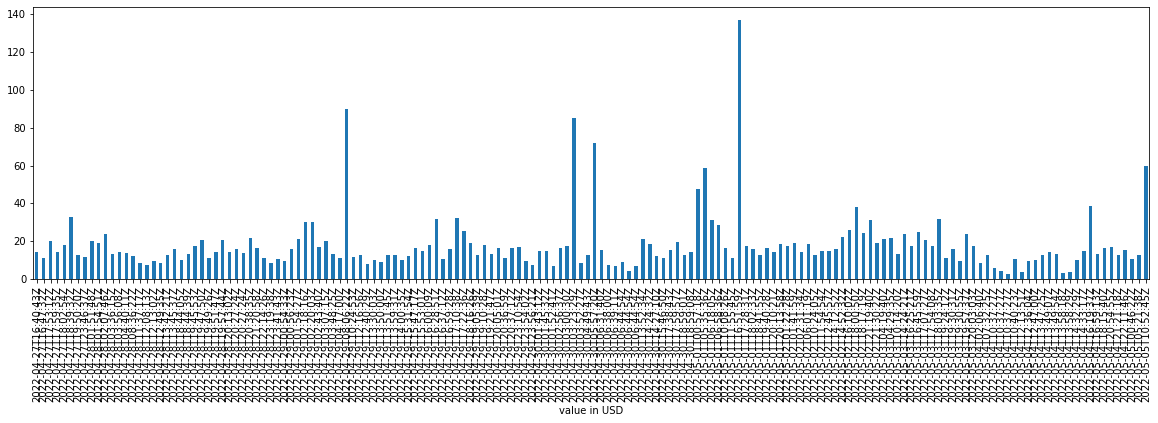

In [25]:
# Filter Through data for non null transactions
cryptopunks_fees = cryptopunks_sales_df['fees_paid'].astype(int)/10**18*eth_value

cryptopunks_fees.plot.bar(rot = 90, figsize = (20,5), xlabel = 'value in USD')

## 3. BAYC Daily Volume

In [26]:
# Create variables needed for owner data and add to url
BAYC_historical_url = url + chain_id + "/nft_market/collection" + BAYC_address + api_no_option

# Get request
BAYC_historical_json = requests.get(BAYC_historical_url).json()

# Convert historical json data to a dataframe and view data
BAYC_df = pd.DataFrame(BAYC_historical_json['data']['items'])

# Set index to date
BAYC_df = BAYC_df.set_index('opening_date')

# Create Volume dataframe
BAYC_vol_df = pd.DataFrame(BAYC_df, columns = ['volume_quote_day', 'unique_token_ids_sold_count_day']).sort_index()
BAYC_vol_df

,volume_quote_day,unique_token_ids_sold_count_day
opening_date,,
2021-04-30,8.241964e+02,1
2021-05-01,1.737182e+06,1635
2021-05-02,4.950946e+06,1534
2021-05-03,3.948996e+06,996
2021-05-04,1.388962e+06,336
...,...,...
2022-04-02,3.924610e+06,6
2022-04-03,3.946992e+06,10
2022-04-04,5.910691e+06,11


<AxesSubplot:xlabel='opening_date'>

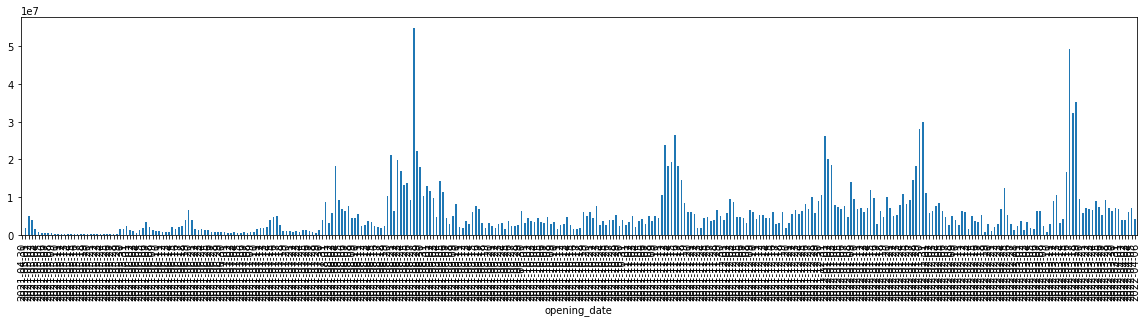

In [27]:
# Plot Volume quote per day
BAYC_volume = BAYC_vol_df['volume_quote_day'].astype(int)

BAYC_volume.plot.bar(figsize = (20,4))

## 3a Historical Sales + Fees paid

In [28]:
# Quering the API for transaction data
BAYC_tx_url = url + chain_id + "/address" + BAYC_address + page_option + api_option 
BAYC_tx = requests.get(BAYC_tx_url).json()

# Convert transactions data to dataframe
BAYC_tx_df = pd.DataFrame(BAYC_tx['data']['items'], columns = ['to_address_label','fees_paid', 'value_quote','block_signed_at']).set_index('block_signed_at').sort_index()

BAYC_tx_df.head()

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-05-02T11:48:41Z,None,6621976694219148,0.0
2022-05-02T11:58:37Z,None,2572512939690200,0.0
2022-05-02T12:04:27Z,None,3074230643705000,0.0
2022-05-02T12:05:44Z,None,45669526655081842,0.0
2022-05-02T12:06:11Z,None,43265970413332940,0.0


<AxesSubplot:xlabel='block_signed_at'>

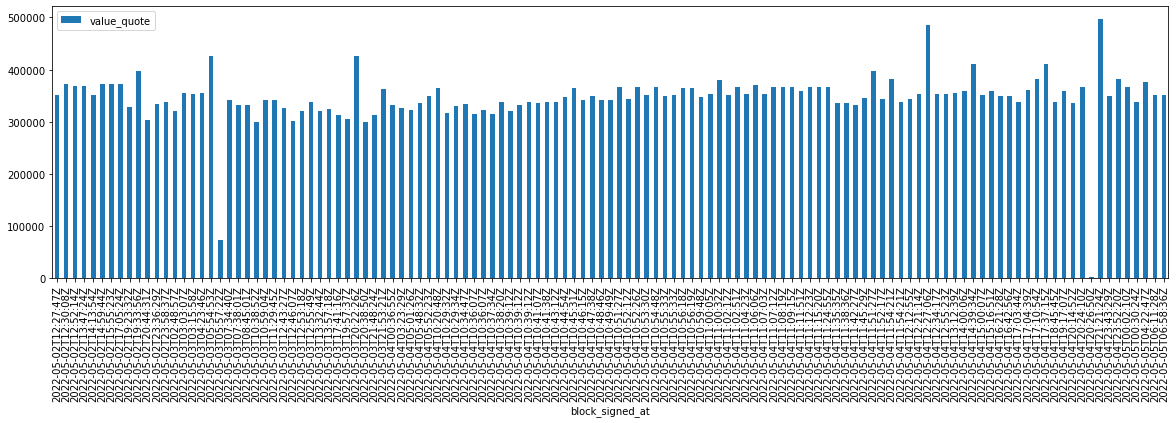

In [29]:
# Filter Through data for non null transactions
BAYC_sales_df = BAYC_tx_df[BAYC_tx_df['value_quote'] != 0]
BAYC_sales = BAYC_sales_df[BAYC_sales_df['to_address_label'].notnull()].dropna()

# View transaction data
BAYC_sales.plot.bar(rot = 90, figsize = (20,5))

## 3.b Fees plot

<AxesSubplot:xlabel='value in USD'>

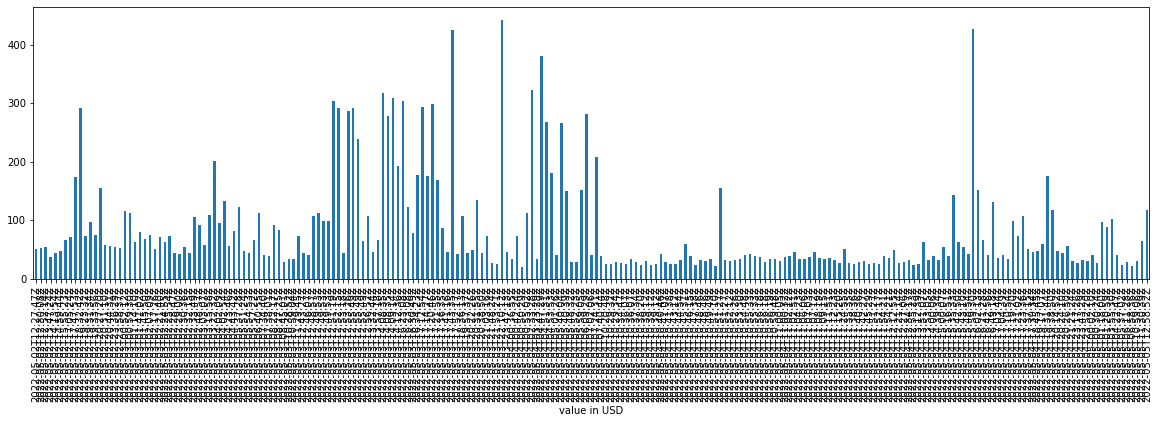

In [30]:
# Filter Through data for non null transactions
BAYC_fees = BAYC_sales_df['fees_paid'].astype(int)/10**18*eth_value

BAYC_fees.plot.bar(rot = 90, figsize = (20,5), xlabel = 'value in USD')